Referências:

[1] REBENTROST, Patrick; MOHSENI, Masoud; LLOYD, Seth. Quantum support vector machine for big data classification. Physical review letters, v. 113, n. 13, p. 130503, 2014. 

[2] PARK, Jae-Eun et al. Practical application improvement to Quantum SVM: theory to practice. arXiv preprint arXiv:2012.07725, 2020.


# QSVM aplicado a um problema de classificação com padrão simples

Elaborado por:
- Equipe Qast - Beer Quantum Challenge (Ambev+QB) 2021

No notebook anterior:

- Mostramos como o Kernel quântico consegue aprender padrões extremamente complexos do database, os quais os kernels clássicos (no mínimo os mais comuns e facilmente computáveis) não conseguem reproduzir.

Porém, complexidade não é sempre um fator positivo, principalmente em casos onde as instâncias estão distribuídas de forma bem mais simples do que no exemplo anterior. 

Neste notebook:

- Vamos mostrar que QSVM consegue ter ótima acurácia em casos mais simples, onde kernels clássicos também performam bem, basta utilizar circuitos quânticos mais simples e regularização (clássica) em $L_2$ !

- Com isso, justificamos a utilização do QSVM mesmo nestes casos mais simples, já que este ainda tem a vantagem de poder ser treinado exponencialmente mais rápido [1]. Ou seja, podemos utilizar mais dados do que o gargalo de complexidade clássico permite e, assim, podemos obter uma maior acurácia!

- Buscamos observar a versatilidade dos kernels quânticos como discutido em [2]

### 1. Importar bibliotecas

In [1]:
#general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#qiskit imports
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.circuit.library import  ZFeatureMap, PauliFeatureMap
from qiskit.aqua.algorithms import QSVM
from qiskit_machine_learning.kernels import QuantumKernel

#scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.svm as svm
from sklearn.metrics import accuracy_score

/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


### 2. Preparar database

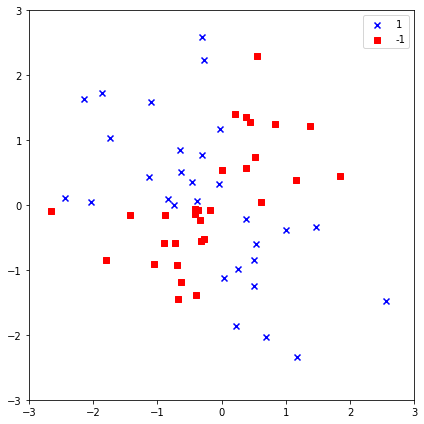

In [19]:
# Import packages to do the classifying
import numpy as np
from sklearn.svm import SVC

# Create Dataset
np.random.seed(2)
X_xor = np.random.randn(60, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

fig = plt.figure(figsize=(6,6))
plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Este database é concebido para que o kernel clássico rbf tenha um ótimo desempenho. O rbf é possivelmente o kernel clássico mais utilizado [2].

### 3. Separar e normalizar dados

In [20]:
#separate
Xtrain, Xtest, ytrain, ytest = train_test_split(X_xor, y_xor, test_size=0.2, random_state=42)

In [21]:
# Standardize
ss = StandardScaler()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.transform(Xtest)

### 4. Classificador clássico

In [22]:
csvc = svm.SVC(kernel='rbf')
csvc.fit(Xtrain, ytrain)
classical_score = csvc.score(Xtest, ytest)

In [23]:
classical_score

0.8333333333333334

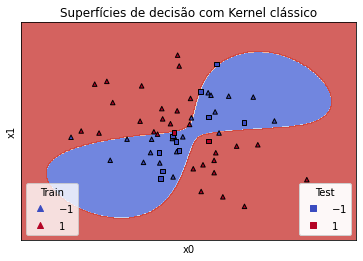

In [24]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


fig, ax = plt.subplots()
title = ('Superfícies de decisão com Kernel clássico')

xx, yy = make_meshgrid(Xtrain[:, 0], Xtrain[:, 1], h = 0.02)
plot_contours(ax, csvc, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
scatter1 = ax.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, cmap=plt.cm.coolwarm, s=20, edgecolors='k', marker = '^')

scatter2 = ax.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, cmap=plt.cm.coolwarm, s=20, edgecolors='k', marker = 's')


ax.set_ylabel('x1')
ax.set_xlabel('x0')
ax.set_xticks(())
ax.set_yticks(())




legend2 = ax.legend(*scatter1.legend_elements(),
                    loc="lower left", title="Train")
ax.add_artist(legend2)

legend3 = ax.legend(*scatter2.legend_elements(),
                    loc="lower right", title="Test")
ax.add_artist(legend3)

ax.set_ylabel('x1')
ax.set_xlabel('x0')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

### 5. Classificador com kernel quântico

In [25]:
feature_map = ZFeatureMap(feature_dimension = 2, reps = 1)
#feature_map = PauliFeatureMap(feature_dimension = 2, reps = 1, paulis = ['Y'])
backend = Aer.get_backend('statevector_simulator')

QKernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

 O circuito a ser utilizado deve ser simples para evitar overfit: somente uma repetição e sem emaranhamento entre os qubits

/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


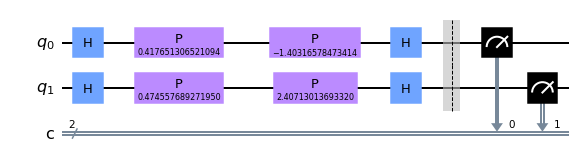

In [26]:
QKernel.construct_circuit(Xtrain[0], Xtrain[1]).decompose().decompose().draw(output= 'mpl')

In [27]:
matrix_train = QKernel.evaluate(x_vec=Xtrain)
matrix_test = QKernel.evaluate(x_vec=Xtest, y_vec=Xtrain)


def q_kernel(X, Y):
    return np.dot(np.dot(X, matrix_train), Y.T)



qsvc = svm.SVC(kernel=q_kernel, C= 0.5)
qsvc.fit(matrix_train, ytrain)
quantum_score = qsvc.score(matrix_test, ytest)

In [28]:
quantum_score

0.5

In [24]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(QKernel.evaluate([xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


fig, ax = plt.subplots()
title = ('Superfícies de decisão com Kernel clássico')

xx, yy = make_meshgrid(Xtrain[:, 0], Xtrain[:, 1], h = 0.5)
plot_contours(ax, qsvc, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
scatter1 = ax.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, cmap=plt.cm.coolwarm, s=20, edgecolors='k', marker = '^')

scatter2 = ax.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, cmap=plt.cm.coolwarm, s=20, edgecolors='k', marker = 's')


ax.set_ylabel('x1')
ax.set_xlabel('x0')
ax.set_xticks(())
ax.set_yticks(())




legend2 = ax.legend(*scatter1.legend_elements(),
                    loc="lower left", title="Train")
ax.add_artist(legend2)

legend3 = ax.legend(*scatter2.legend_elements(),
                    loc="lower right", title="Test")
ax.add_artist(legend3)

ax.set_ylabel('x1')
ax.set_xlabel('x0')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()


#Pode levar vário minutos para executar